<div style="float:left">
            <h1 style="width:450px">CASA0006 Practical 2: Supervised learning</h1>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

# Welcome!

In this workshop, we will achieve the following objectives:
1. Review weekly quiz;
1. Build a decision tree model to predict the daily bicycle rental based on metrics of R2 and RMSE;
1. Tune the hyperparameter of maximal tree height of this model, using two ways of validation.

Remember that *Practice makes perfect.*

In the following code, some codes are missing and marked with ```??```.

Please replace ```??``` with the correct codes, using the hints and context. The solution will be given in the workshop.

\*\* Review the weekly quiz \*\*.

First, import the relevant libraries. 

* `pandas` for data import and handling;
* `matplotlib`;
* `numpy`;
* `sklearn`;
* `statsmodels` for linear regression and VIF.

**Run the script below to get started.**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve

import statsmodels.api as sm

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

## Data Loading and Exploration

The dataset you will use relates to daily counts of rented bicycles from the bicycle rental company Capital-Bikeshare in Washington D.C., along with weather and seasonal information. The goal here is to predict how many bikes will be rented depending on the weather and the day. The original data can be downloaded from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

The dataset used in this workshop has been slightly processed by Christoph Molnar using the processing R-script from this [Github repository](https://github.com/christophM/interpretable-ml-book/blob/master/R/get-bike-sharing-dataset.R). Here, the dataset is provided as a csv file on Moodle.

Here is a list of the variables in the dataset:

- Count of bicycles including both casual and registered users. The count is used as the response in the regression task.
- Indicator of the season, either spring, summer, fall or winter.
- Indicator whether the day was a holiday or not.
- The year: either 2011 or 2012.
- Number of days since the 01.01.2011 (the first day in the dataset). This predictor was introduced to take account of the trend over time.
- Indicator whether the day was a working day or weekend.
- The weather situation on that day. One of:
  - **'GOOD'**: including clear, few clouds, partly cloudy, cloudy
  - **'MISTY'**: including mist + clouds, mist + broken clouds, mist + few clouds, mist
  - **'RAIN/SNOW/STORM'**: including light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds, heavy rain + ice pallets + thunderstorm + mist, snow + mist
- Temperature in degrees Celsius.
- Relative humidity in percent (0 to 100).
- Wind speed in km/h.

We will use Pandas package to load and explore this dataset:

- Import the bicycle rental dataset as a Pandas dataframe (call it `bike_rental`)
- Inspect the data
- Calculate summary statistics on all attributes

In [3]:
bike_rental = pd.read_csv('https://raw.githubusercontent.com/huanfachen/Spatial_Data_Science/main/Dataset/daily_count_bike_rental.csv')
# drop the year variable as it is not useful
bike_rental = bike_rental.drop(['yr'], axis=1)

In [4]:
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cnt              731 non-null    int64  
 1   season           731 non-null    object 
 2   mnth             731 non-null    object 
 3   holiday          731 non-null    object 
 4   weekday          731 non-null    object 
 5   workingday       731 non-null    object 
 6   weathersit       731 non-null    object 
 7   temp             731 non-null    float64
 8   hum              731 non-null    float64
 9   windspeed        731 non-null    float64
 10  days_since_2011  731 non-null    int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 62.9+ KB


In [5]:
# print a few rows of this dataset
bike_rental.head()

,cnt,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
0,985,SPRING,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.1758,80.5833,10.7499,0
1,801,SPRING,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.0835,69.6087,16.6521,1
2,1349,SPRING,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.2291,43.7273,16.6367,2
3,1562,SPRING,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.4000,59.0435,10.7398,3
4,1600,SPRING,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.6670,43.6957,12.5223,4


In `bike_rental`, there are two data types: categorical (aka `object`), and numerical (including `int64` and `float64`). 

Before undertaking regression, some dat aprocessing should be done, which include:
- Converting categorical variables into dummy variables (aka one-hot encoding);
- Split the data into training and testing sets;
- For linear regression, we should deal with multicollinearity (and removing some variables if necessary)

One note, the reason for doing one-hot encoding is that sklearn decision trees don't handle categorical data. However, other packages have more efficient ways of handling cateogical variables than one-hot encoding for tree-based models.

We will discuss this issue in more depth next week. Currently, we stick to one-hot encoding.

See [this Stackoverflow post](https://stackoverflow.com/questions/38108832/passing-categorical-data-to-sklearn-decision-tree) for related discussion.

### Converting categorical variables
First, we need to convert categorical variables into dummy/indicator variables, using `One-Hot Encoding`.

In [6]:
bike_rentail_numeric = pd.get_dummies(bike_rental)

In [7]:
# check out the new dataFrame
bike_rentail_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cnt                         731 non-null    int64  
 1   temp                        731 non-null    float64
 2   hum                         731 non-null    float64
 3   windspeed                   731 non-null    float64
 4   days_since_2011             731 non-null    int64  
 5   season_FALL                 731 non-null    bool   
 6   season_SPRING               731 non-null    bool   
 7   season_SUMMER               731 non-null    bool   
 8   season_WINTER               731 non-null    bool   
 9   mnth_APR                    731 non-null    bool   
 10  mnth_AUG                    731 non-null    bool   
 11  mnth_DEZ                    731 non-null    bool   
 12  mnth_FEB                    731 non-null    bool   
 13  mnth_JAN                    731 non

Remember that, a cateogircal variable of K categories or levels, usually enters a regression as a sequence of K-1 dummy variables. The level that is left out becomes the reference level, and this is important for interpreting the regression model.

Here we manually choose the reference level for each categorical variable and exclude them from the DataFrame. You can change the reference levels if you want.

In [8]:
bike_rental_final = bike_rentail_numeric.drop(['season_SPRING', 'mnth_JAN', 'holiday_NO HOLIDAY', 'weekday_MON', 'workingday_WORKING DAY', 'weathersit_GOOD'], axis=1)

# double check the result
bike_rental_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cnt                         731 non-null    int64  
 1   temp                        731 non-null    float64
 2   hum                         731 non-null    float64
 3   windspeed                   731 non-null    float64
 4   days_since_2011             731 non-null    int64  
 5   season_FALL                 731 non-null    bool   
 6   season_SUMMER               731 non-null    bool   
 7   season_WINTER               731 non-null    bool   
 8   mnth_APR                    731 non-null    bool   
 9   mnth_AUG                    731 non-null    bool   
 10  mnth_DEZ                    731 non-null    bool   
 11  mnth_FEB                    731 non-null    bool   
 12  mnth_JUL                    731 non-null    bool   
 13  mnth_JUN                    731 non

### Splitting data into random train and test subsets

By default, `train_test_split` will split the data according to a 75:25 split. Other proportions can be specified, check out the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for details.

Remember that the split should be random in order to avoid selection bias. Here, we set random_state=100 to guarantee reproducibility.

From the documentation:

The first argument of this function:

```
*arrays: sequence of indexables with same length / shape[0]
Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.
```

The output of this function:
```
splitting: list, length=2 * len(arrays)
List containing train-test split of inputs.
```

Here we input two dataframes (X and Y) and will get four outputs (train_x, test_x, train_y, test_y).

In [9]:
random_state_split = 100
train_x, test_x, train_y, test_y = train_test_split(bike_rental_final.drop(['cnt'], axis = 1), bike_rental_final.cnt, random_state=random_state_split)

Double check the rows and columns of the outputs.

In [10]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(548, 28)
(548,)
(183, 28)
(183,)
True
True


In the regression models, we will use the training set to train the model and select hyperparameters. The testing set is only used to report the performance of the finalised model.

## Build a regression tree

We will use a regression tree for this dataset.

While there are several hyperparameters in this model such as **max_depth** (referring to the height of a tree), in the first attempt we just use the default settings.

One question: what is the default value or setting of **max_depth**? Can you get the answer from the documentation?

```
max_depthint, default=None
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
```

In [11]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(random_state=0)
# if you don't remember the meaning of random_state, check out the lastest clustering workshop on Moodle
reg_tree.fit(train_x, train_y)

DecisionTreeRegressor(random_state=0)

In [12]:
print("R2 on the training data:")
print(reg_tree.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(reg_tree.score(X=test_x, y=test_y))

R2 on the training data:
1.0
R2 on the testing data:
0.7229453566227575


It looks like the R2 on the testing data is much lower than that on the training data. This indicates the overfitting problem, meaning that the model fits very well to the training data but doesn't generalise well to unseen data.

If you prefer RMSE as the performance metric, you can calculate it as follows (see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error)):

In [13]:
from sklearn.metrics import mean_squared_error
print("RMSE on the training data:")
print(mean_squared_error(train_y, reg_tree.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, reg_tree.predict(test_x), squared=False))

RMSE on the training data:
0.0
RMSE on the testing data:
986.8989988239838


## Tuning hyperparameters of the ML model

In machine learning, hyperparameters are the model settings predefined by the user, e.g. maximum height of the decision tree.

We will demonstrate how to tune the hyperparameters, using the maximum height of a decision tree (which is called `max_depth` for `DecisionTreeRegressor` in sklearn) as an example.

Some intuition about how the maximum tree height affects the performance of decision tree: the larger the maximum tree height, the better fitness of the model and thus the higher possibility of overfitting.

So, ideally, we want the maximum tree height to be neither too small or too large. But, what is the optimal value? This will be answered by hyperparameter tuning.



Let's see if we can tune the model hyperparameters by maximising model performance on the development dataset. There are two ways of hyperparameter tuning:

1. Holdout validation (by splitting the training data into two subsets - training and development data)
2. Cross validation

The pros and cons of these methods are as follows:

| Method      | Pros |Cons |
| ----------- | ----------- |----------- |
| Holdout Validation  | Computationally efficient, well-suited for large datasets |Subject to split of training and validation sets, results might be not robust |
| Cross Validation | Less subject to data split, results are robust |Computationally inefficient for big datasets |


We will demonstrate both ways using the **GridSearchCV** function from sklearn. The documentation of this function is [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

### Holdout validation

The documentation of **GridSearchCV** indicates different ways of specifying the **cv** parameter:
```
cv: int, cross-validation generator or an iterable, default=None
Determines the cross-validation splitting strategy. Possible inputs for cv are:

- None, to use the default 5-fold cross validation,

- integer, to specify the number of folds in a (Stratified)KFold,

- CV splitter,

- An iterable yielding (train, test) splits as arrays of indices.
```

To use holdout validation, we can set the cv as a list of (train, test) that indicates the indices of training and testing data.

In [14]:
# the index list of training and validation data in the merged dataset
# we will use the first 75% rows of [train_x, train_y] as training set and the following 25% rows as validation set
# index of the first 75% rows (rounded to integer)
n_row_training = np.floor(train_x.shape[0]*0.75).astype(int)
ind_train = list(range(n_row_training))
# index of the remaining rows
ind_val = list(range(n_row_training, train_x.shape[0]))

In [15]:
# values of max_depth
hyperparameters = {'max_depth':[10,20,30,40,50]}

randomState_dt = 10000
dt = DecisionTreeRegressor(random_state=randomState_dt)

# CV: An iterable yielding (train, test) splits as arrays of indices.
clf = GridSearchCV(dt, hyperparameters, cv=[(ind_train, ind_val)])

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'max_depth': 30}
The best score is: 
0.7253171537913115


Now, print out the optimal number of trees. Note that if you change the random_state in the ```RandomForestRegressor```, you may get a different ```best_params_``` but the ```best_score_``` is quite similar across different runs. This is because the randomisation in creating ```RandomForestRegressor```.

We can create the final random forest model using the optimal hyperparameters.

In [16]:
dt_final = DecisionTreeRegressor(max_depth=clf.best_params_['max_depth'], random_state=randomState_dt)
dt_final.fit(train_x, train_y)

DecisionTreeRegressor(max_depth=30, random_state=10000)

After tuning the hyperparameters, we are able to evaluate the performance of the model to inspect bias and variance.

Note that the score on teh validation data is the same as the ```clf.best_score_```.

In [17]:
print('The score on the training data:')
print(dt_final.score(train_x, train_y))
print('The score on the testing data:')
print(dt_final.score(test_x, test_y))

The score on the training data:
1.0
The score on the testing data:
0.7337776508078722


### Cross-validation

Cross validation is preferred over the holdout validation method in real-world machine learning projects, as the results are more robust.

In [18]:
# values of max_depth
hyperparameters = {'max_depth':[10,20,30,40,50]}

randomState_dt = 10000
dt = DecisionTreeRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(dt, hyperparameters)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'max_depth': 10}
The best score is: 
0.7451947631296068


Sometimes, it is helpful to plot the influence of a single hyperparameter on the training and development score to find out whether the model is overfitting or underfitting. This plot is called **Validation curve**.

The function ```validation_score``` is helpful in this case. Similar to ```GridSearchCV```, this function is based on cross-validation.

In [19]:
max_depth_range = [10,20,30,40,50]

train_scores, valid_scores = validation_curve(estimator=DecisionTreeRegressor(), 
                                              X=train_x, y=train_y, 
                                              param_name="max_depth",
                                              param_range=max_depth_range,
                                              cv=5)

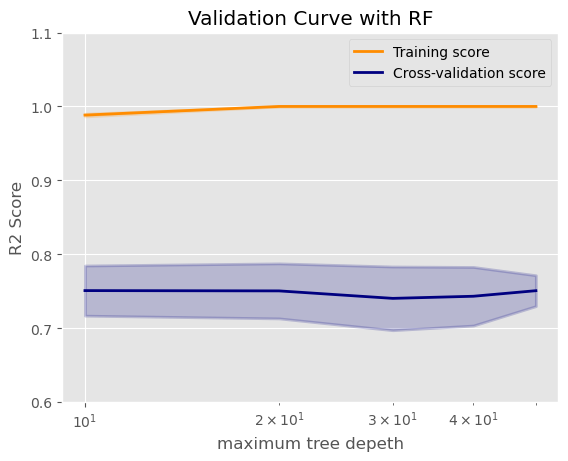

In [20]:
# plotting the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve with RF")
plt.xlabel(r"maximum tree depth")
plt.ylabel("R2 Score")
plt.ylim(0.6, 1.1)
lw = 2
plt.semilogx(max_depth_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(max_depth_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(max_depth_range, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(max_depth_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

It looks like the training and development scores do not change significantly with max depth.

You can pick up the point where the gap between training and cross-validation score reaches the minimum as the selected hyperparameter.

In fact, in GridSearch, we can tune the combination of multiple hyperparameters. We will discuss this issue in later weeks.

Similar to hold-out validation, we can create the final random forest model using the optimal hyperparameters.

In [21]:
dt_final = DecisionTreeRegressor(max_depth=clf.best_params_['max_depth'], random_state=randomState_dt)
dt_final.fit(train_x, train_y)

DecisionTreeRegressor(max_depth=10, random_state=10000)

After tuning the hyperparameters, we are able to evaluate the performance of the model on the testing data.

In [22]:
print('The score on the training data:')
print(dt_final.score(train_x, train_y))
print('The score on the testing data:')
print(dt_final.score(test_x, test_y))

The score on the training data:
0.9890472695830228
The score on the testing data:
0.7350074821879649


## Summary

In this workshop, we have covered the analysis workflow of supervised learning, using an example of building regression trees to predict daily bicycle rentals.

## References and recommendations:

1. This notebook is partially based on a [chapter](https://christophm.github.io/interpretable-ml-book/limo.html) of the [book](https://christophm.github.io/interpretable-ml-book/) by Christoph Molnar. 
1. This notebook is partially based on [this notebook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.03-Hyperparameters-and-Model-Validation.ipynb), which is part of the [online repo](https://jakevdp.github.io/PythonDataScienceHandbook/) of the book ["Python Data Science Handbook"](https://www.oreilly.com/library/view/python-data-science/9781491912126/).
